#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [3]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
# run this cell only the first time you run the notebook
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
To: /Users/ernestobocini/Documents/GitHub/EPFL_COURSES/Semester_2/NX-414/week5/IT_data.h5
 10%|▉         | 37.2M/384M [00:03<00:43, 7.99MB/s]

KeyboardInterrupt: 

In [4]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np

### Load the data

In [5]:
path_to_data = 'data' 

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [6]:
stimulus_train.shape

(2592, 3, 224, 224)

In [7]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


There are 64 different objects in the dataset


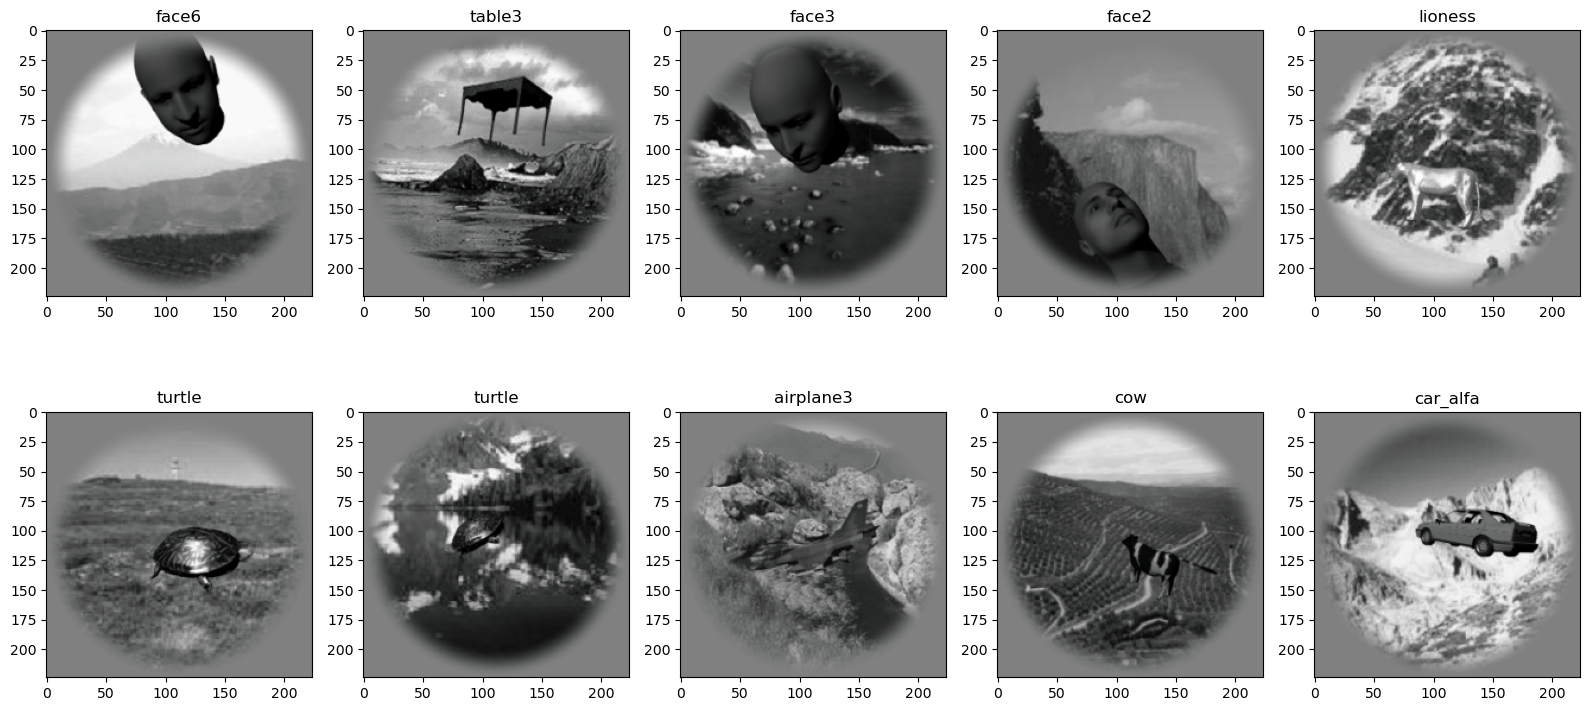

In [8]:
# let's explore the data before the analysis

# how many different objects are in the dataset?
print('There are {} different objects in the dataset'.format(len(set(objects_train))))

# let's visualize the first 10 images
idxs = np.arange(10)
visualize_imgs(stimulus_train, objects_train, idxs)


the number of stimulus with face6 object is: 325
the number of different face objects (different orientation of faces) is: 8


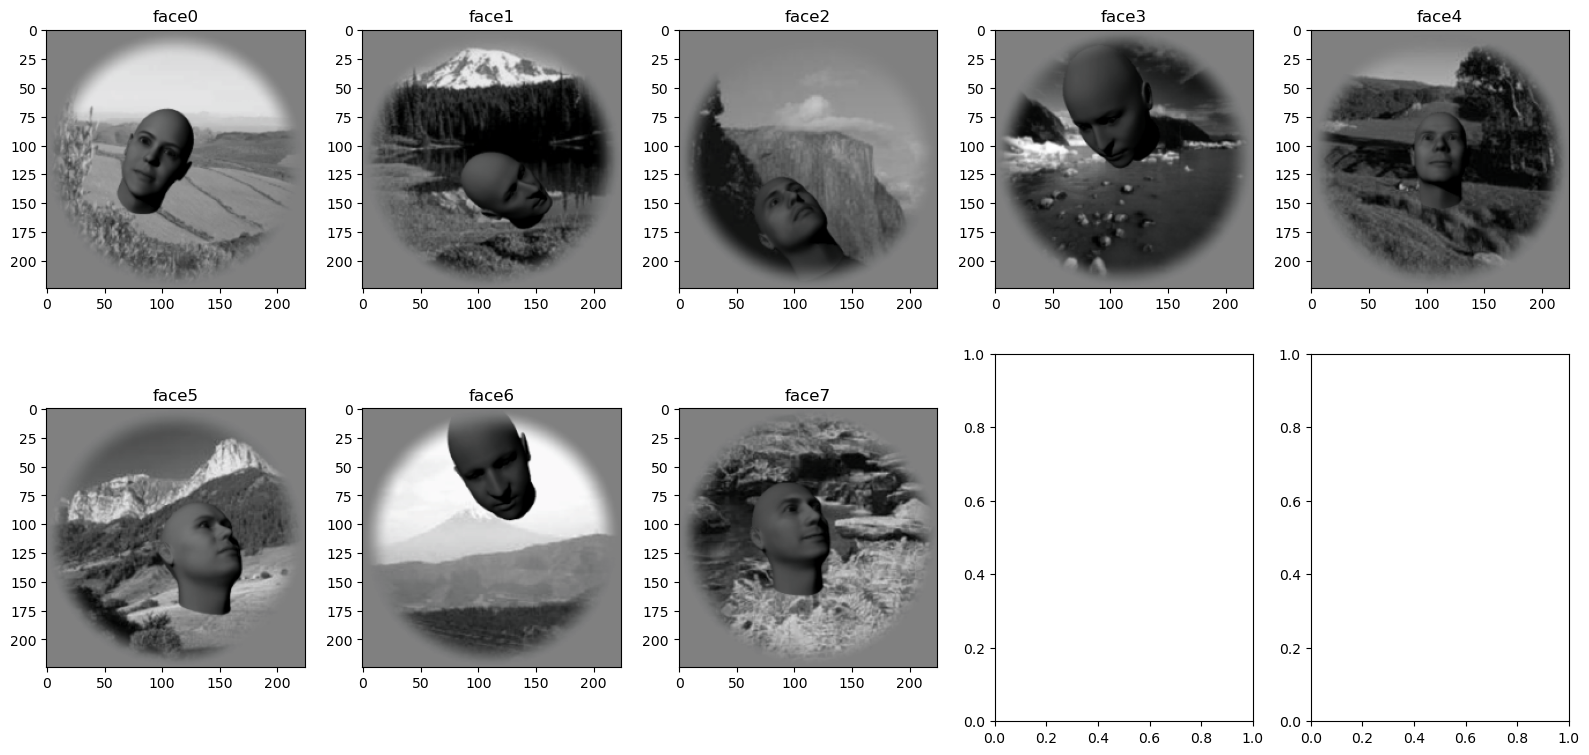

In [9]:
# to understand the data better, let's visualize the data for face objects only
face_pos = create_mask(objects_train, 'face')
print_category(stimulus_train, objects_train, face_pos)

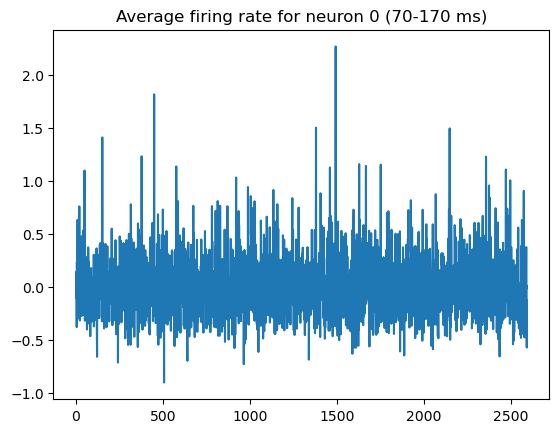

In [10]:
# we can now visualize the neuron response to the different stimuli
neuron_idx = 0

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])
# note that each point represents average respose of the neuron over 100 ms to a different stimulus
# in fact there are 2592 peaks in the plot

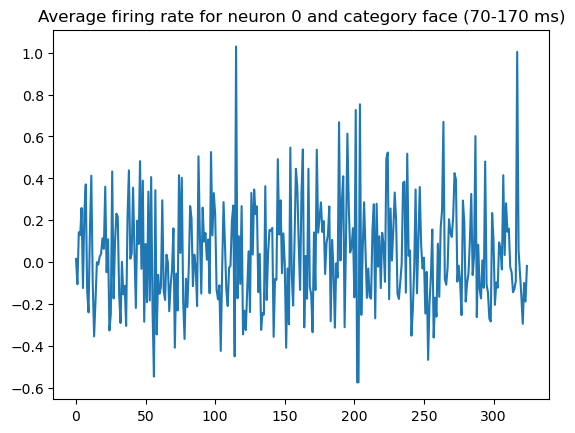

In [11]:
# now same plot as before, but only for the peaks corresponding to faces stimuli

plot_average_firing_rate_for_category(spikes_train, face_pos, neuron_idx, 'face')

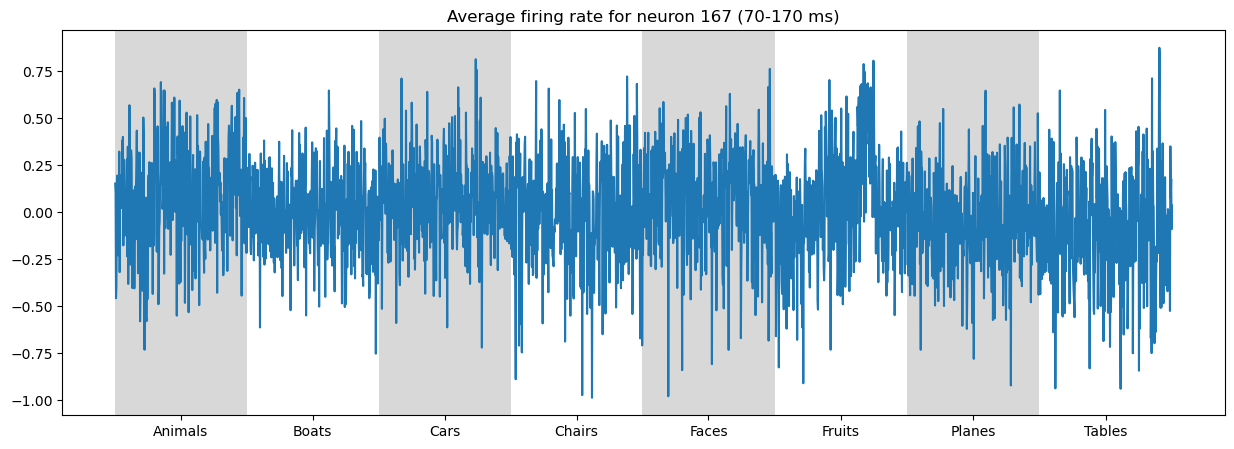

In [12]:
plot_average_firing_rate_for_all_categories_merged(objects_train, spikes_train, 167)

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [13]:
# create a different objects_train and objects_val with only 8 categories

fruits = ['apple', 'apricot', 'peach', 'pear', 'raspberry', 'strawberry', 'walnut', 'watermelon']
animals = ['bear', 'cow', 'dog', 'elephant', 'gorilla', 'hedgehog', 'lioness', 'turtle']

objects_train_8 = objects_train.copy()
objects_val_8 = objects_val.copy()

objects_train_8 = ['face' if 'face' in s else s for s in objects_train_8]
objects_train_8 = ['car' if 'car' in s else s for s in objects_train_8]
objects_train_8 = ['chair' if 'chair' in s else s for s in objects_train_8]
objects_train_8 = ['airplane' if 'airplane' in s else s for s in objects_train_8]
objects_train_8 = ['table' if 'table' in s else s for s in objects_train_8]
objects_train_8 = ['fruit' if s in fruits else s for s in objects_train_8]
objects_train_8 = ['animal' if s in animals else s for s in objects_train_8]
objects_train_8 = ['ship' if 'ship' in s else s for s in objects_train_8]

objects_val_8 = ['face' if 'face' in s else s for s in objects_val_8]
objects_val_8 = ['car' if 'car' in s else s for s in objects_val_8]
objects_val_8 = ['chair' if 'chair' in s else s for s in objects_val_8]
objects_val_8 = ['airplane' if 'airplane' in s else s for s in objects_val_8]
objects_val_8 = ['table' if 'table' in s else s for s in objects_val_8]
objects_val_8 = ['fruit' if s in fruits else s for s in objects_val_8]
objects_val_8 = ['animal' if s in animals else s for s in objects_val_8]
objects_val_8 = ['ship' if 'ship' in s else s for s in objects_val_8]


(set(objects_train_8))


{'airplane', 'animal', 'car', 'chair', 'face', 'fruit', 'ship', 'table'}

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from tqdm import tqdm
# the dependent variable is the average firing rate of the neuron over 100 ms
# the independent variable is the category of the stimulus, therefore we have 8 categories
# Animals, Boats, Cars, Chairs, Faces, Fruits, Planes, Tables

# Reshape the stimulus array to have dimensions (2592, 150528) to be compatible with the 
# dependent variable.
stimulus_train_res = stimulus_train.reshape((stimulus_train.shape[0], -1))
print('the reshaped stimulus_train array has shape: ', stimulus_train_res.shape)

# Encode the image category using one-hot encoding
print(set(objects_train_8))
label_econder = LabelEncoder()
category_labels = label_econder.fit_transform(objects_train)
caregory_labels_8 = label_econder.fit_transform(objects_train_8)


onehot_encoder = OneHotEncoder(categories='auto')
category_onehot = onehot_encoder.fit_transform(category_labels.reshape(-1, 1)).toarray()

category_onehot_8 = onehot_encoder.fit_transform(caregory_labels_8.reshape(-1, 1)).toarray()
print('The one-hot encoded image category has shape: ', category_onehot.shape)
print('The one-hot encoded image category has shape: ', category_onehot_8.shape)


# Combine the reshaped stimulus array and the one-hot encoded image category into a single 
# feature matrix with dimensions (2592, 150536).
feature_matrix = np.concatenate((stimulus_train_res, category_onehot), axis=1)
feature_matrix_8 = np.concatenate((stimulus_train_res, category_onehot_8), axis=1)
print(feature_matrix.shape)
print(feature_matrix_8.shape)


the reshaped stimulus_train array has shape:  (2592, 150528)
{'table', 'car', 'airplane', 'fruit', 'face', 'ship', 'chair', 'animal'}
The one-hot encoded image category has shape:  (2592, 64)
The one-hot encoded image category has shape:  (2592, 8)


 10%|▉         | 38.3M/384M [00:20<00:43, 7.99MB/s]

(2592, 150592)
(2592, 150536)


In [29]:
# Create a linear regression model and fit it to the data.
reg = LinearRegression(fit_intercept=True).fit(feature_matrix, spikes_train)
reg_ridge = Ridge(alpha=1, fit_intercept=True).fit(feature_matrix, spikes_train)

reg_8 = LinearRegression(fit_intercept=True).fit(feature_matrix_8, spikes_train)
reg_ridge_8 = Ridge(alpha=1, fit_intercept=True).fit(feature_matrix_8, spikes_train)


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

{'table', 'animal', 'car', 'fruit', 'airplane', 'face', 'ship', 'chair'}
Correlation score: mean=0.14837632841184237, std=0.09574529804028412
Explained variance score: mean=-1.1500082691584583, std=0.392041262016522
R2 score: mean=-1.1596536813064906, std=0.39331606145090664
Correlation score ridge: mean=0.14851996096155823, std=0.09580502713321716
Explained variance score ridge: mean=-1.1459677917457773, std=0.39071296173254666
R2 score ridge: mean=-1.155586907657632, std=0.39197995019318294
Correlation score 8: mean=0.1544781471066973, std=0.09653961888142129
Explained variance score 8: mean=-1.1256743645141822, std=0.39488534236668515
R2 score 8: mean=-1.135311696580894, std=0.39624159458942104
Correlation score ridge 8: mean=0.15462412233057243, std=0.09659916992154033
Explained variance score ridge 8: mean=-1.121663153067054, std=0.39353768951704354
R2 score ridge 8: mean=-1.1312741367995383, std=0.39488573472896404


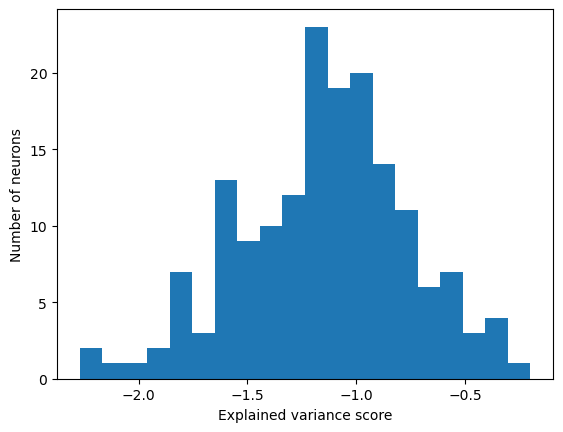

In [16]:
from sklearn.metrics import explained_variance_score, r2_score

# create feature_test_matrix
#stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val

#Reshape stimulus_val
stimulus_val_res = stimulus_val.reshape((stimulus_val.shape[0], -1))

#Encode the image category using one-hot encoding
label_econder = LabelEncoder()
category_labels_val = label_econder.fit_transform(objects_val)
category_labels_val_8 = label_econder.fit_transform(objects_val_8)
print(set(objects_val_8))

onehot_encoder = OneHotEncoder(categories='auto')
category_onehot_val = onehot_encoder.fit_transform(category_labels_val.reshape(-1, 1)).toarray()
category_onehot_val_8 = onehot_encoder.fit_transform(category_labels_val_8.reshape(-1, 1)).toarray()

#Combine the reshaped stimulus array and the one-hot encoded image category into a single matrix
feature_val_matrix = np.concatenate((stimulus_val_res, category_onehot_val), axis=1)
feature_val_matrix_8 = np.concatenate((stimulus_val_res, category_onehot_val_8), axis=1)

# Predict firing rates on the test set
spikes_pred = reg.predict(feature_val_matrix)
spikes_pred_ridge = reg_ridge.predict(feature_val_matrix)
spikes_pred_8 = reg_8.predict(feature_val_matrix_8)
spikes_pred_ridge_8 = reg_ridge_8.predict(feature_val_matrix_8)
#spikes_pred = reg.predict(stimulus_val_res)

# Compute correlation and explained variance for each neuron
corr_scores = []
corr_scores_ridge = []
corr_scores_8 = []
corr_scores_ridge_8 = []
exp_var_scores = []
exp_var_scores_ridge = []
exp_var_scores_8 = []
exp_var_scores_ridge_8 = []
r2_scores = []
r2_scores_ridge = []
r2_scores_8 = []
r2_scores_ridge_8 = []
for i in range(spikes_val.shape[1]):
    corr = np.corrcoef(spikes_val[:, i], spikes_pred[:, i])[0, 1]
    corr_ridge = np.corrcoef(spikes_val[:, i], spikes_pred_ridge[:, i])[0, 1]
    corr_8 = np.corrcoef(spikes_val[:, i], spikes_pred_8[:, i])[0, 1]
    corr_ridge_8 = np.corrcoef(spikes_val[:, i], spikes_pred_ridge_8[:, i])[0, 1]
    corr_scores.append(corr)
    corr_scores_ridge.append(corr_ridge)
    corr_scores_8.append(corr_8)
    corr_scores_ridge_8.append(corr_ridge_8)
    exp_var = explained_variance_score(spikes_val[:, i], spikes_pred[:, i])
    exp_var_ridge = explained_variance_score(spikes_val[:, i], spikes_pred_ridge[:, i])
    exp_var_8 = explained_variance_score(spikes_val[:, i], spikes_pred_8[:, i])
    exp_var_ridge_8 = explained_variance_score(spikes_val[:, i], spikes_pred_ridge_8[:, i])
    exp_var_scores.append(exp_var)
    exp_var_scores_ridge.append(exp_var_ridge)
    exp_var_scores_8.append(exp_var_8)
    exp_var_scores_ridge_8.append(exp_var_ridge_8)
    r2 = r2_score(spikes_val[:, i], spikes_pred[:, i])
    r2_ridge = r2_score(spikes_val[:, i], spikes_pred_ridge[:, i])
    r2_8 = r2_score(spikes_val[:, i], spikes_pred_8[:, i])
    r2_ridge_8 = r2_score(spikes_val[:, i], spikes_pred_ridge_8[:, i])
    r2_scores.append(r2)
    r2_scores_ridge.append(r2_ridge)
    r2_scores_8.append(r2_8)
    r2_scores_ridge_8.append(r2_ridge_8)

# Print the mean and standard deviation of correlation and explained variance scores
print("Correlation score: mean={}, std={}".format(np.mean(corr_scores), np.std(corr_scores)))
print("Explained variance score: mean={}, std={}".format(np.mean(exp_var_scores), np.std(exp_var_scores)))
print("R2 score: mean={}, std={}".format(np.mean(r2_scores), np.std(r2_scores)))

print("Correlation score ridge: mean={}, std={}".format(np.mean(corr_scores_ridge), np.std(corr_scores_ridge)))
print("Explained variance score ridge: mean={}, std={}".format(np.mean(exp_var_scores_ridge), np.std(exp_var_scores_ridge)))
print("R2 score ridge: mean={}, std={}".format(np.mean(r2_scores_ridge), np.std(r2_scores_ridge)))

print("Correlation score 8: mean={}, std={}".format(np.mean(corr_scores_8), np.std(corr_scores_8)))
print("Explained variance score 8: mean={}, std={}".format(np.mean(exp_var_scores_8), np.std(exp_var_scores_8)))
print("R2 score 8: mean={}, std={}".format(np.mean(r2_scores_8), np.std(r2_scores_8)))

print("Correlation score ridge 8: mean={}, std={}".format(np.mean(corr_scores_ridge_8), np.std(corr_scores_ridge_8)))
print("Explained variance score ridge 8: mean={}, std={}".format(np.mean(exp_var_scores_ridge_8), np.std(exp_var_scores_ridge_8)))
print("R2 score ridge 8: mean={}, std={}".format(np.mean(r2_scores_ridge_8), np.std(r2_scores_ridge_8)))

# Plot the distribution of explained variance across neurons

plt.hist(exp_var_scores, bins=20)
plt.xlabel("Explained variance score")
plt.ylabel("Number of neurons")
plt.show()

In [17]:
spikes_val[:, 1].shape, spikes_pred[:, 1].shape

((288,), (288,))

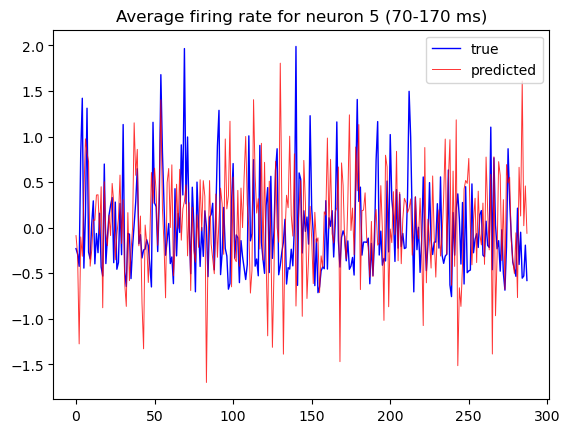

In [18]:
n_idx = 5
plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(n_idx))
plt.plot(spikes_val[:,n_idx], color='blue', label='true', linewidth=1)
plt.plot(spikes_pred[:,n_idx], color = 'red', alpha = .8, label='predicted', linewidth=.7)
plt.legend()


##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [22]:
stimulus_train_res.shape

(2592, 150528)

In [23]:
# Find the 1000 PCs of the stimulus

from sklearn.decomposition import PCA

n_comp = 1000

pca = PCA(n_components=n_comp)
# TODO: fit the generated patches to the ICA (~1 line):
pca.fit(stimulus_train_res)
# TODO: get components from the PCA (~1 line):
pca_filters = pca.components_
pca_features_train = pca.transform(stimulus_train_res)
print(pca_features_train.shape)


(2592, 1000)


In [24]:
# Take 1000 PCs for the validation set as well
pca_features_val = pca.transform(stimulus_val_res)
print(pca_features_val.shape)

(288, 1000)


In [25]:
# Now join them with the object_8 filters

pca_feature_matrix_8 = np.concatenate((pca_features_train, category_onehot_8), axis=1)
print(pca_feature_matrix_8.shape)

# same for validation set
pca_feature_matrix_8_val = np.concatenate((pca_features_val, category_onehot_val_8), axis=1)
print(pca_feature_matrix_8_val.shape)

(2592, 1008)
(288, 1008)


In [26]:
spikes_train.shape

(2592, 168)

In [27]:
pca_reg_ridge_8 = Ridge(alpha=1).fit(pca_feature_matrix_8, spikes_train)

Correlation score ridge 8: mean=0.3525724485921883, std=0.14653593335267967
Explained variance score ridge 8: mean=0.03613587213844024, std=0.17218646972383905
R2 score ridge 8: mean=0.03145406321301062, std=0.17331755644240424


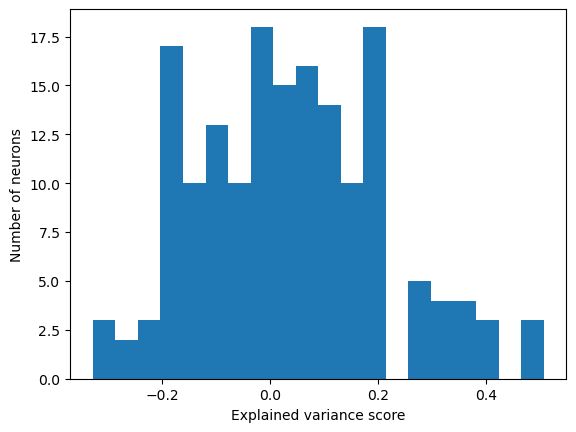

In [28]:
corr_scores = []
exp_var_scores = []
r2_scores = []



spikes_pred_pca = pca_reg_ridge_8.predict(pca_feature_matrix_8_val)

for i in range(spikes_val.shape[1]):
    corr = np.corrcoef(spikes_val[:, i], spikes_pred_pca[:, i])[0, 1]
    corr_scores.append(corr)
    exp_var = explained_variance_score(spikes_val[:, i], spikes_pred_pca[:, i])
    exp_var_scores.append(exp_var)
    r2 = r2_score(spikes_val[:, i], spikes_pred_pca[:, i])
    r2_scores.append(r2)

print("Correlation score ridge 8: mean={}, std={}".format(np.mean(corr_scores), np.std(corr_scores)))
print("Explained variance score ridge 8: mean={}, std={}".format(np.mean(exp_var_scores), np.std(exp_var_scores)))
print("R2 score ridge 8: mean={}, std={}".format(np.mean(r2_scores), np.std(r2_scores)))

# Plot the distribution of explained variance across neurons
import matplotlib.pyplot as plt

plt.hist(exp_var_scores, bins=20)
plt.xlabel("Explained variance score")
plt.ylabel("Number of neurons")
plt.show()

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
#### Here your code